<a href="https://colab.research.google.com/github/Divyaanshvats/FIDROX_ASSIGNMENTS/blob/main/FIDROX_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **AccessAI: Detecting Anomalous Swipe Behavior in Physical Access Control Systems(ML)**

# **IMPORT ALL THE REQUIRE LIBRARIES**

In [34]:
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta
import os
np.random.seed(42)
random.seed(42)
NUM_DAYS = 30
SWIPES_PER_DAY = 1000
TOTAL_RECORDS = NUM_DAYS * SWIPES_PER_DAY
user_ids = [f"U{str(i).zfill(3)}" for i in range(1, 101)]
doors = {
    "D01": "Main Entrance",
    "D02": "East Wing",
    "D03": "Server Room",# restricted
    "D04": "HR Department",
    "D05": "Rooftop Access",# rarely used
    "D06": "Finance Room",
    "D07": "Cafeteria",
    "D08": "Basement Storage",# rarely used
}

# **RANDOM GENERATION OF DATASET(SAME AS DBSCAN)**

In [35]:
data = []
start_date = datetime(2025, 5, 1)
for i in range(TOTAL_RECORDS):
    current_date = start_date + timedelta(days=i // SWIPES_PER_DAY)
    if np.random.rand() < 0.8:
        hour = np.random.randint(8, 19)
    else:
        hour = np.random.choice([0, 1, 2, 3, 4, 22, 23])

    minute = np.random.randint(0, 60)
    second = np.random.randint(0, 60)
    timestamp = current_date.replace(hour=hour, minute=minute, second=second)
    user = random.choice(user_ids)
    door = random.choices(list(doors.keys()), weights=[25, 20, 5, 15, 2, 10, 20, 3])[0]
    direction = random.choice(["IN", "OUT"])
    result = "Success" if np.random.rand() > 0.05 else "Failed"
    if np.random.rand() < 0.01:
        for _ in range(5):
            anomaly_timestamp = timestamp + timedelta(seconds=random.randint(1, 30))
            data.append([anomaly_timestamp, user, door, doors[door], direction, "Failed"])

    data.append([timestamp, user, door, doors[door], direction, result])
df = pd.DataFrame(data, columns=["Timestamp", "UserID", "DoorID", "DoorName", "Direction", "Result"])
df.head()

,Timestamp,UserID,DoorID,DoorName,Direction,Result
0,2025-05-01 18:07:20,U082,D01,Main Entrance,OUT,Success
1,2025-05-01 15:52:35,U032,D01,Main Entrance,IN,Success
2,2025-05-01 15:43:29,U087,D06,Finance Room,IN,Success
3,2025-05-01 17:21:43,U076,D02,East Wing,IN,Failed
4,2025-05-01 10:43:54,U012,D01,Main Entrance,IN,Success


In [36]:
output_path = "/mnt/data/AccessAI_Simulated_Swipe_Logs.csv"
output_dir = os.path.dirname(output_path)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
df.to_csv(output_path, index=False)
output_path

'/mnt/data/AccessAI_Simulated_Swipe_Logs.csv'

In [37]:
df = pd.read_csv("/mnt/data/AccessAI_Simulated_Swipe_Logs.csv")
df.head(3)

,Timestamp,UserID,DoorID,DoorName,Direction,Result
0,2025-05-01 18:07:20,U082,D01,Main Entrance,OUT,Success
1,2025-05-01 15:52:35,U032,D01,Main Entrance,IN,Success
2,2025-05-01 15:43:29,U087,D06,Finance Room,IN,Success


In [38]:
len(df)#length of dataset

31505

# **SVM**

In [39]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['Hour'] = df['Timestamp'].dt.hour
df['IsOddHour'] = (df['Hour'] % 2 != 0).astype(int)
df['IsRestrictedDoor'] = df['DoorID'].isin(['D03', 'D05', 'D08']).astype(int)
df['DirectionEncoded'] = df['Direction'].apply(lambda x: 1 if x == 'IN' else 0)
df['DoorEncoded'] = df['DoorID'].astype('category').cat.codes
df['IsFailed'] = (df['Result'] == 'Failed').astype(int)

In [40]:
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler

# Select features and scale
X = df[["Hour", "IsOddHour", "IsRestrictedDoor", "DirectionEncoded", "DoorEncoded"]]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train on only normal swipes
X_train = X_scaled[df["IsFailed"] == 0]

model = OneClassSVM(kernel='rbf', gamma=0.05, nu=0.05)
model.fit(X_train)

OneClassSVM(gamma=0.05, nu=0.05)

In [41]:
df['svm_pred'] = model.predict(X_scaled)
df['svm_anomaly'] = (df['svm_pred'] == -1).astype(int)

In [9]:
print("Total anomalies detected:", df['svm_anomaly'].sum())
df[df['svm_anomaly'] == 1].head()

Total anomalies detected: 1517


,Timestamp,UserID,DoorID,DoorName,Direction,Result,Hour,IsOddHour,IsRestrictedDoor,DirectionEncoded,DoorEncoded,IsFailed,svm_pred,svm_anomaly
22,2025-05-01 00:52:05,U021,D03,Server Room,OUT,Success,0,0,1,0,2,0,-1,1
29,2025-05-01 03:53:22,U083,D03,Server Room,OUT,Success,3,1,1,0,2,0,-1,1
73,2025-05-01 01:48:27,U007,D05,Rooftop Access,IN,Success,1,1,1,1,4,0,-1,1
80,2025-05-01 00:34:47,U020,D01,Main Entrance,IN,Success,0,0,0,1,0,0,-1,1
83,2025-05-01 22:12:58,U075,D03,Server Room,IN,Success,22,0,1,1,2,0,-1,1


In [42]:
print("Anomalies Detected:", df['svm_anomaly'].sum())

Anomalies Detected: 1517


In [43]:
df['svm_score'] = model.decision_function(X_scaled)
df['svm_score'].head()

,svm_score
0,47.328383
1,75.197466
2,102.044846
3,89.795608
4,80.754989


In [44]:
df[df['svm_anomaly'] == 0].sort_values('svm_score').tail()

,Timestamp,UserID,DoorID,DoorName,Direction,Result,Hour,IsOddHour,IsRestrictedDoor,DirectionEncoded,DoorEncoded,IsFailed,svm_pred,svm_anomaly,svm_score
14724,2025-05-15 10:52:42,U045,D04,HR Department,OUT,Success,10,0,0,0,3,0,1,0,129.055165
14513,2025-05-14 10:16:55,U083,D04,HR Department,OUT,Success,10,0,0,0,3,0,1,0,129.055165
15501,2025-05-15 10:16:54,U055,D04,HR Department,OUT,Success,10,0,0,0,3,0,1,0,129.055165
23881,2025-05-23 10:04:37,U072,D04,HR Department,OUT,Failed,10,0,0,0,3,1,1,0,129.055165
24270,2025-05-24 10:15:52,U056,D04,HR Department,OUT,Success,10,0,0,0,3,0,1,0,129.055165


In [45]:
df[df['svm_anomaly'] == 1].sort_values('svm_score').tail()

,Timestamp,UserID,DoorID,DoorName,Direction,Result,Hour,IsOddHour,IsRestrictedDoor,DirectionEncoded,DoorEncoded,IsFailed,svm_pred,svm_anomaly,svm_score
31501,2025-05-30 22:34:55,U048,D07,Cafeteria,IN,Success,22,0,0,1,6,0,-1,1,-0.000001
1192,2025-05-02 22:22:51,U099,D07,Cafeteria,IN,Success,22,0,0,1,6,0,-1,1,-0.000001
16573,2025-05-16 22:58:25,U003,D07,Cafeteria,IN,Success,22,0,0,1,6,0,-1,1,-0.000001
31320,2025-05-30 22:42:11,U087,D07,Cafeteria,IN,Success,22,0,0,1,6,0,-1,1,-0.000001
838,2025-05-01 22:51:14,U024,D07,Cafeteria,IN,Success,22,0,0,1,6,0,-1,1,-0.000001


In [46]:
print(f"Total Records: {len(df)}")
print(f"Anomalies Flagged by SVM: {df['svm_anomaly'].sum()}")
print(f"Max Anomaly Score: {df['svm_score'].max():.4f}")
print(f"Min Anomaly Score: {df['svm_score'].min():.4f}")
print(f"Mean Score (Normal): {df[df['svm_anomaly']==0]['svm_score'].mean():.4f}")
print(f"Mean Score (Anomaly): {df[df['svm_anomaly']==1]['svm_score'].mean():.4f}")

Total Records: 31505
Anomalies Flagged by SVM: 1517
Max Anomaly Score: 129.0552
Min Anomaly Score: -68.3235
Mean Score (Normal): 76.9013
Mean Score (Anomaly): -10.6065


# **Lets Check this now for Multiple values of nu**

In [47]:
from sklearn.svm import OneClassSVM

nu_values = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08]

for nu in nu_values:
    model = OneClassSVM(kernel='rbf', gamma='scale', nu=nu)
    model.fit(X_train)

    preds = model.predict(X_scaled)
    anomaly_count = (preds == -1).sum()

    print(f"ν = {nu:.2f} → anomalies detected: {anomaly_count}")

ν = 0.01 → anomalies detected: 2474
ν = 0.02 → anomalies detected: 2463
ν = 0.03 → anomalies detected: 2452
ν = 0.04 → anomalies detected: 2352
ν = 0.05 → anomalies detected: 2812
ν = 0.06 → anomalies detected: 2514
ν = 0.07 → anomalies detected: 2294
ν = 0.08 → anomalies detected: 2998


In [48]:
print(X_train.shape)
print(X_scaled.shape)

(28478, 5)
(31505, 5)


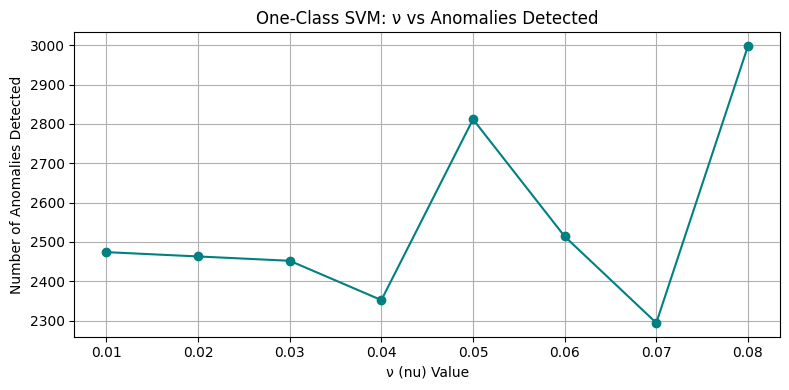

In [49]:
import matplotlib.pyplot as plt

nu_values = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08]
anomaly_counts = [2474, 2463, 2452, 2352, 2812, 2514, 2294, 2998]

plt.figure(figsize=(8, 4))
plt.plot(nu_values, anomaly_counts, marker='o', linestyle='-', color='teal')
plt.title("One-Class SVM: ν vs Anomalies Detected")
plt.xlabel("ν (nu) Value")
plt.ylabel("Number of Anomalies Detected")
plt.xticks(nu_values)
plt.grid(True)
plt.tight_layout()
plt.show()

# **PCA ANALYSIS**

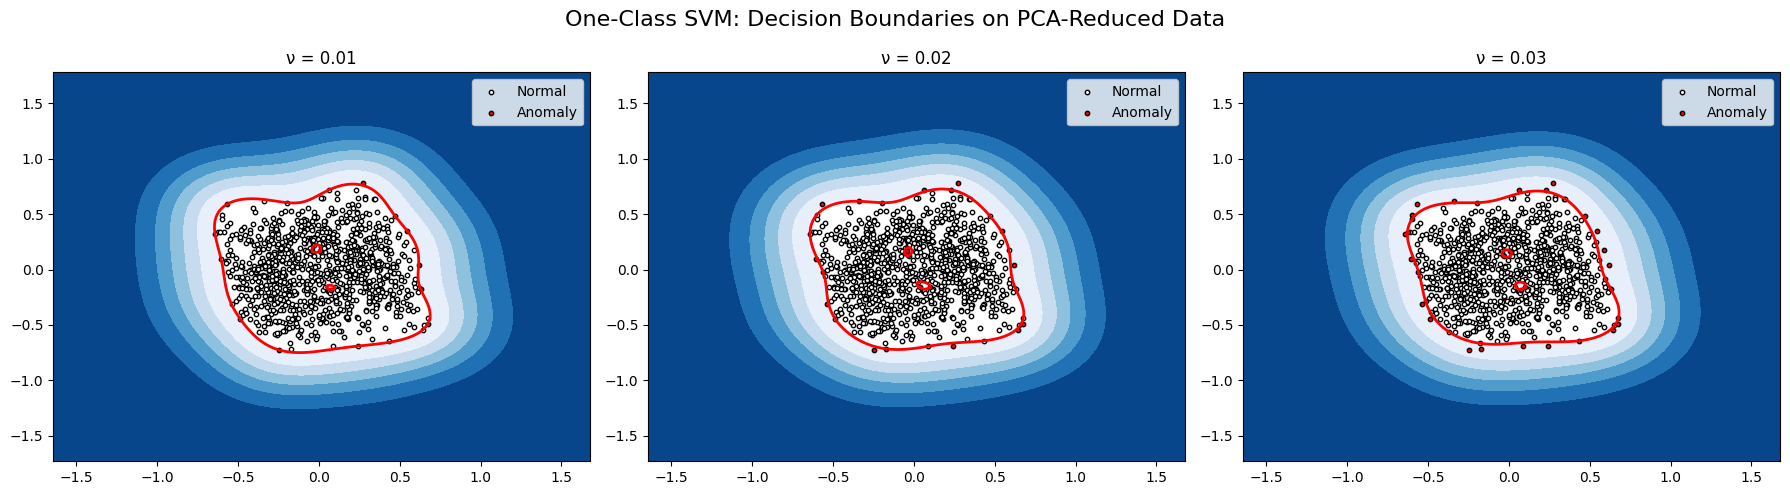

In [50]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.svm import OneClassSVM

# Simulate X_train and X_scaled for demo (replace with your actual data)
# Let's assume X_scaled is the same as X_train for this visualization
# In your case, use your own preprocessed X_scaled and X_train values
np.random.seed(42)
X_scaled = np.random.rand(1000, 4)  # 4 features -> just for PCA

# Reduce dimensions using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Set up ν values to visualize
nu_values = [0.01, 0.02, 0.03]
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, nu in enumerate(nu_values):
    model = OneClassSVM(kernel='rbf', gamma='scale', nu=nu)
    model.fit(X_pca)
    preds = model.predict(X_pca)

    xx, yy = np.meshgrid(np.linspace(X_pca[:, 0].min() - 1, X_pca[:, 0].max() + 1, 200),
                         np.linspace(X_pca[:, 1].min() - 1, X_pca[:, 1].max() + 1, 200))
    Z = model.decision_function(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axes[i].contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.Blues_r)
    axes[i].contour(xx, yy, Z, levels=[0], linewidths=2, colors='red')  # boundary
    axes[i].scatter(X_pca[preds == 1, 0], X_pca[preds == 1, 1], c='white', s=10, edgecolors='k', label='Normal')
    axes[i].scatter(X_pca[preds == -1, 0], X_pca[preds == -1, 1], c='red', s=10, edgecolors='k', label='Anomaly')
    axes[i].set_title(f"ν = {nu}")
    axes[i].legend()

fig.suptitle("One-Class SVM: Decision Boundaries on PCA-Reduced Data", fontsize=16)
plt.tight_layout()
plt.show()

In [56]:
df['ResultNum'] = df['Result'].map({'Success': 0, 'Failed': 1})
X = df[['Hour', 'IsRestrictedDoor', 'IsOddHour', 'IsFailed', 'ResultNum']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [58]:
# Step 1: Scale all features (if not done already)
from sklearn.preprocessing import StandardScaler

# Step 2: Train on all scaled data
model = OneClassSVM(kernel='rbf', gamma='scale', nu=0.03)
model.fit(X_scaled)

# Step 3: Predict on same data
preds = model.predict(X_scaled)

# Step 4: Save to df
df['svm_pred'] = preds
df['svm_anomaly'] = (df['svm_pred'] == -1).astype(int)

In [59]:
print("Total anomalies detected:", df['svm_anomaly'].sum())#PCA-reduced data (~1,000 points) Hence not Not directly comparable

Total anomalies detected: 5052


In [53]:
df[df['svm_anomaly'] == 1].sample(5)[['Timestamp', 'UserID', 'DoorID', 'Direction', 'Result']]

,Timestamp,UserID,DoorID,Direction,Result
19836,2025-05-19 22:12:12,U003,D03,IN,Success
26278,2025-05-26 11:28:42,U053,D01,OUT,Failed
21247,2025-05-21 01:41:25,U029,D02,OUT,Success
13645,2025-05-13 08:15:47,U023,D03,OUT,Failed
5689,2025-05-06 01:02:12,U055,D06,OUT,Success
